In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

# Approximate Bayesian Computation

The dominant issue in applying Bayesian methods to data analysis is the feasibility of calculating the posterior distribution. As we have seen, for most non-trivial problems, the posterior is analytically intractible. Computationally, it can be expensive to calculate or sample from.

Approximation methods do exist, such as the Laplace approximation, but it relies on strong assumptions about the form of the posterior.

Approximate Bayesian Computation (ABC) is a simulation-based approximation approach that avoids having to calculate the model likelihood, as we do for MCMC sampling. For this reason, it is sometimes called ***likelihood-free computation*** or ***likelihood-free MCMC***. Instead of evaluating the estimated posterior distribution at sampled values of the parameters, candidate parameters sample from their *prior* distribtions are used to generate simulated datasets; if the simulated data are deemed to be "similar enough" to the observed data, the proposed parameters are accepted. In this way, the data are thought to lend support to parameter values that might have generated them over those for which the observations would be less probable. 

## Likelihood-free computation

As is often the case in statistical computing, one effective strategy for improving compuational efficiency is to introduce auxilliary variables into a model. Such variables are solely for the purpose of facilitating computation, and play no role in inference.

For approximate Bayesian computation, we do just this, augmenting the posterior with auxilliary data $x$:

$$P(\theta, x \,|\, y) \propto P(y \,|\, \theta, x) P(x \,|\, \theta) P(\theta)$$

Upon inspection, we see that $x$ is drawn from a sampling distribution that is conditional on the prior of the parameter vector $\theta$. Note also that since $x$ is sampled from the same parametric model as $y$, it occupies the same space as $y$.

Ultimately, we want to integrate the auxilliary data from the posterior:

$$P(\theta \,|\, y) \propto \left[\int P(y \,|\, \theta, x) P(x \,|\, \theta) dx\right] P(\theta)$$

Of course, we are not able to perform this integration analytically. The thrust of ABC is that we integrate numerically by keeping samples from $P(\theta)$ that generate sample which closely correspond to observed data (*i.e.* approximating the sampling process that generated $y$), and discarding the rest.

Notice that when $x=y$, the augmented posterior becomes the posterior of interest:

$$\left[\int P(y \,|\, \theta, x=y) P(x=y \,|\, \theta) dx\right] P(\theta) = P(y \,|\, \theta) P(\theta)$$

Thus, a naïve form of ABC is to simulate from the prior, accepting only those parameters that result in simulated datasets that are exactly equivalent to the observed data $y$.

This rejection algorithm is as follows:

1. Sample parameters $\theta^{(i)}$ from priors $P(\theta)$.
2. Simulate data $x^{(i)}$ from sampling distributions $x \sim P(x \,|\, \theta^{(i)})$.
3. If $x^{(i)}==y$, keep $\theta^{(i)}$ as sample from posterior.
4. Repeat steps 1-3 until desired number of samples is obtained.

Of course, for continuous variables, the sampled data will never be exactly equal to the observed data, and even for discrete variables sampling will be painfully inefficient. In order for ABC to be effective, we have to relax the check for equality, and accept samples that are merely "close enough" to the observed data. 

This simple change involves making two important choices: (1) deciding how to measure "closeness" and (2) deciding how close is "close enough"? In general, however, we can specify some function $\rho(a, b)$ that returns some distance measure between $a$ and $b$, and compare this output to a chosen threshold value $\epsilon$. With these changes, the ABC rejection algorithm becomes:

1. Sample parameters $\theta^{(i)}$ from priors $P(\theta)$.
2. Simulate data $x^{(i)}$ from sampling distributions $x \sim P(x \,|\, \theta^{(i)})$.
3. If $\rho(x, y) < \epsilon$, keep $\theta^{(i)}$ as sample from posterior.
4. Repeat steps 1-3 until desired number of samples is obtained.

A popular choice of distance measure is the Euclidean distance, which is provided in NumPy as `np.linalg.norm`. 

$$||x - y|| = \sqrt{(x_1-y_1)^2 + \ldots + (x_n-y_n)^2}< \epsilon$$

The quality of the approximation of the posterior depends on the choice of the tolerance $\epsilon$. When $\epsilon$ is too small, sampling will be inefficient; when $\epsilon$ is too large, estimates will more strongly resemble the model priors. The convergence properties of ABC as a function of $\epsilon$ are not clear.

### Summary statistics

When data are of high (even moderate) dimension, comparing each datum in a simulated dataset with each corresponding datum in an observed dataset can result in low sampling efficiency; the probability of all simulated data simultaneously falling within the tolerance bound $\epsilon$ of the observed data gets very small for a fixed $\epsilon$ as the size of the dataset grows. Instead, *summary statistics* may be compared in order to keep the acceptance rate high.

$$\rho(T(x), T(y)) < \epsilon$$

For example, one might consider the mean, variance, autocorrelation, tail probabilities, *etc.* of the simulated and observed datasets. The use of summary statistics comes at a cost, however, since there is generally information loss upon summarization that results in estimation error. This compromise can be avoided if **sufficient statistics** are available, since sufficiency guarantees that all information about the posterior distribution is captured by that statistic.

## Example: Fitting a Gaussian

A very simple demonstration of ABC is to estimate the parameters of a particular statistical model. For example, let's simulate some data from a $N(4, 2)$ distibution:

(array([  1.,   0.,   2.,   5.,  11.,   8.,   9.,   9.,   2.,   3.]),
 array([-2.80186752, -1.67584599, -0.54982446,  0.57619707,  1.7022186 ,
         2.82824013,  3.95426165,  5.08028318,  6.20630471,  7.33232624,
         8.45834777]),
 <a list of 10 Patch objects>)

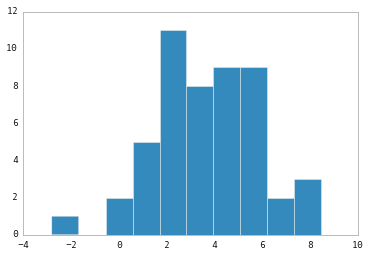

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

y = np.random.normal(4, 2, 50)
plt.hist(y)

To set up the ABC run, we first specify how many samples we want to draw from the posterior, as well as a tolerance for the distance measure to be used as the criterion for accepting or rejecting drawn values. Then, we need a data structure to store the accepted samples:

In [4]:
N = 100
epsilon = [0.2, 0.8]

trace = []

The algorithm then invloves repeatedly sampling from the priors on $\mu$ and $\sigma$, and using those draws to simulate some data. The mean and standard deviation of the simulations are compared to those for the observed data, and the corresponding parameter samples are stored if the distance is within the specified threshold.

In [5]:
while len(trace) < N:
    
    # Simulate from priors
    mu = np.random.normal(0, 10)
    sigma = np.random.uniform(0, 20)
    
    x = np.random.normal(mu, sigma, 50)
    
    #if (np.linalg.norm(y - x) < epsilon):
    if ((abs(x.mean() - y.mean()) < epsilon[0]) & 
        (abs(x.std() - y.std()) < epsilon[1])):
        trace.append([mu, sigma])
        
trace = pd.DataFrame(trace, columns=['mu', 'sigma'])

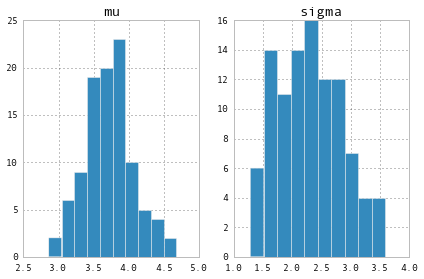

In [6]:
trace.hist()
plt.tight_layout()

### Example: Coal mining disasters

For a less trivial example, consider the following dataset, which is a time series of recorded coal mining disasters in the UK from 1851 to 1962 ([Jarrett 1979](http://www.jstor.org/stable/2335266)). Notice that the number of disasters each year appears to be lower in the later years than earlier.

Annual counts of disasters in the dataset can be modeled as a Poisson process with a larger rate parameter early in the time series, and and a smaller rate in the later part. We are interested
in locating the change point in the series, which perhaps is related to changes in mining safety regulations.

In [9]:
disasters_array = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                         3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                         2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                         1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                         0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                         3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                         0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

In this example, we will compare the norms of the simulated and observed data, sorting them, since we are comparing based on the distribtion of the values, and not their order:

    np.linalg.norm(np.sort(x_early) - np.sort(disasters_array[:switch]))
    
The priors for the Poisson means are sampled from an exponential distribution with mean 1, and the switch point from a discrete uniform over all the years.

In [12]:
N = 100
epsilon = 2

# Dict for holding accepted samples
params = dict(switch=[], early_mean=[], late_mean=[])
    
while len(params['switch']) < N:
        
    # Simulate from priors
    switch = np.random.randint(15, 90)
    early_mean = np.random.exponential(1)
    late_mean = np.random.exponential(1)
    
    # Simulate data
    x_early = np.random.poisson(early_mean, switch)
    x_late = np.random.poisson(late_mean, 111 - switch)
    
    if ((np.linalg.norm(np.sort(x_early) - np.sort(disasters_array[:switch])) < epsilon) & 
        (np.linalg.norm(np.sort(x_late) - np.sort(disasters_array[switch:])) < epsilon)):
        
        params['switch'].append(switch)
        params['early_mean'].append(early_mean)
        params['late_mean'].append(late_mean)

trace = pd.DataFrame(params)

KeyboardInterrupt: 

In [ ]:
trace.hist(bins=np.sqrt(N))

## Model comparison

The approximate Bayesian computing approach can also be used for model selection, where several models are considered simultaneously. In addition to the parameters of each model, the inference considers the *model index* $M$, which is associated with its own prior distribution $P(m)$ $(m = 1,...,M)$, as well as a prior distribution on the parameters conditional on the value $m$ of the model index, $P_m(\theta_m)$, defined on the parameter space $\theta_m$. 

Discrimination among these models is then driven by the posterior distribution of $M$, a challenging computational target where ABC brings a straightforward solution. If $M$ is simply considered an additional parameter to be estimated, we can sample from its prior distribution just as with the model parameters.

The algorithm is as follows:

- Loop for N iterations:
    - while $\rho(T(x), T(y)) > \epsilon$:
        - sample $m$ from prior $P(m)$
        - sample $\theta_m$ from prior $P_m(\theta_m)$
        - simulate data x from model $f_m(x|\theta_m)$
    - set $m^{(i)} = m$ and $\theta^{(i)} = \theta_m$
    
As a contrived example, consider some data sampled from a *Gamma(10, 2)* distribution, where we are uncertain about the generating model. 

In [22]:
n = 200
simdata = np.random.gamma(10,2,n)

(array([  4.,  17.,  29.,  36.,  44.,  29.,  21.,   5.,   5.,  10.]),
 array([  5.99775652,   9.33886963,  12.67998274,  16.02109584,
         19.36220895,  22.70332206,  26.04443516,  29.38554827,
         32.72666138,  36.06777449,  39.40888759]),
 <a list of 10 Patch objects>)

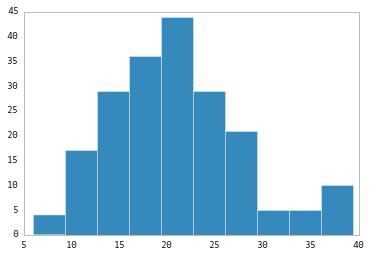

In [23]:
plt.hist(simdata, bins=10)

We might consider fitting a Gaussian distribution to this data, as an alternative to the Gamma. Thus, we can constuct an ABC model choice sampler for $M=2$ models:

In [24]:
N = 500

epsilon = [20, 10, 5]

trace = dict(normal=[], gamma=[])

def accept(x, simdata, e=epsilon):
    
    return ((abs(np.log(x.prod()) - np.log(simdata.prod())) < e[0]) & 
            (abs(x.sum() - simdata.sum()) < e[1]) &
            (abs(x.std() - simdata.std()) < e[2]))
    

while (len(trace['normal']) + len(trace['gamma'])) < N:
    
    gamma = np.random.binomial(1, 0.5)
    
    if gamma:
                
        alpha, beta = np.random.exponential(10, 2)
        
        x = np.random.gamma(alpha, beta, n)
        
        if accept(x, simdata):
            trace['gamma'].append([alpha, beta])
    
    else:
        
        # Simulate from priors
        mu = np.random.normal(0, 10)
        sigma = np.random.uniform(0, 20)
        
        x = np.random.normal(mu, sigma, n)
            
        if accept(x, simdata):
            trace['normal'].append([mu, sigma])
            

In [25]:
trace['gamma'][:10], trace['normal'][:10]

([[3.7685583930245818, 5.4865086739503042],
  [8.3537029654537349, 2.5994968122333972],
  [14.243896788191551, 1.498453827248629],
  [7.2530666837074254, 2.9130769102288072],
  [14.116535854471735, 1.4839523621734185],
  [11.880099302944465, 1.7675869885600828],
  [6.0702470137099969, 3.3412998164591374],
  [11.198815277080168, 1.8620145374298049],
  [37.529331906156223, 0.56371975558251675],
  [26.483387823214155, 0.81323638931145581]],
 [[21.195591029887684, 5.61513457747637],
  [20.30637140512448, 9.032891692124416],
  [20.959194301822762, 7.017085381522938],
  [21.23903534480616, 2.4985976611561855],
  [21.470218654319755, 5.214749982021507],
  [21.03472305909362, 3.296579649762319],
  [21.038286545414483, 4.762632275554859],
  [20.255379026353644, 8.603215918055959],
  [21.743672763085012, 6.325931230981093],
  [20.73668146261243, 3.402376632545965]])

The ABC estimate of the posterior probability $P(m|y)$ is simply the acceptance frequency from model $m$:

$$Pr(m) = \frac{1}{N} \sum_{i=1}^N I(m^{(i)}=m)$$

In [26]:
p_gamma = len(trace['gamma'])/float(N)
p_gamma

0.802

Once the posterior probabilities of models have been estimated, one can make full use of the techniques of Bayesian model comparison. For instance, to compare the relative plausibilities of two models $m=1$ and $m=2$, one can compute their posterior ratio, which is related to the Bayes factor $B_{1,2}$:

$$\frac{P(m=1|y)}{P(m=2|y)} = \frac{P(y|m=1)P(m=1)}{P(y|m=2)P(m=2)} = B_{1,2}\frac{P(m=1)}{P(m=2)}$$

In [18]:
B12 = (p_gamma)/(1-p_gamma)
B12

2.311258278145695

## Exercise: ABC for bioassay analysis

Implement an ABC scheme for estimating the parameters of the dose-response model for bioassay analysis.

In [28]:
dose = np.array([-0.86, -0.3 , -0.05,  0.73])
deaths = np.array([0, 1, 3, 5])

In [ ]:
# Code your model here

## References

Sunnåker, M., Busetto, A. G., Numminen, E., Corander, J., Foll, M., & Dessimoz, C. (2013). Approximate Bayesian Computation. PLoS Computational Biology, 9(1), e1002803. [doi:10.1371/journal.pcbi.1002803](http://www.ploscompbiol.org/article/info:doi/10.1371/journal.pcbi.1002803)

Csilléry, K., Blum, M. G. B., Gaggiotti, O. E., & François, O. (2010). Approximate Bayesian Computation (ABC) in practice. Trends in Ecology & Evolution, 25(7), 410–418. [doi:10.1016/j.tree.2010.04.001](http://www.ncbi.nlm.nih.gov/pubmed/20488578)

Marin, J.-M., Pudlo, P., Robert, C. P., & Ryder, R. J. (2011). Approximate Bayesian computational methods. Statistics and Computing, 22(6), 1167–1180. [doi:10.1007/s11222-011-9288-2](http://link.springer.com/content/pdf/10.1007%2Fs11222-011-9288-2.pdf)

[The Rate of Convergence for Approximate Bayesian Computation](http://m.seehuhn.de/papers/ABC.pdf) by Stuart Barber, Jochen Voss and Mark Webster